In [1]:
import torch

from torch import nn
from torch import optim
from time import gmtime, strftime
from tensorboardX import SummaryWriter
import tqdm as tqdm
import matplotlib.pyplot as plt


import os

from resnet2d_ecg import *
from data_generator_ecg import *
from tools import *

In [2]:
torch.manual_seed(1)
torch.cuda.manual_seed(1)
# torch.cuda.set_device(2)
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
num_classes = 1
#model = Globalocal(depth=34, num_classes=num_classes, with_lateral = [0,0,1,1], Net_type = 'with_global_detail').cuda()
# model = Globalocal(depth=34, num_classes=num_classes, with_lateral = False , Net_type = 'with_global').cuda()
# model = nn.DataParallel(model)

model = ResNet(dataset='calc', depth=10, num_classes=num_classes).cuda()


here


In [3]:
valconfig = {"dataset": "calc","subset": '1'}
val_config = dataconfig(**valconfig)
validation_data = DataGenerator(val_config,transform= None)
val_loader = DataLoader(validation_data, num_workers=1)

In [7]:
# GLnet with only L
model_load_path = r'E:\Data\Medlink\QualityControl\model_train\resnet10_lrwarmup\Sun03May2020-023244\save'
model_name = r'\best_model.pth'
# torch.cuda.set_device(3)
# model_load_path = '/data1/Image_data/Mammography_data/log/resnet_result/GLwithLateral/Wed14Aug2019-061426/save/'
# model_name = 'save_180.pth'
criterion = nn.BCELoss()

In [8]:
checkpoint = torch.load(model_load_path + model_name)
model.load_state_dict(checkpoint['state_dict'])

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [9]:
model.cuda()
# model.load_state_dict(checkpoint['state_dict'])

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (drop): Dropout(p=0.5)
    )
  )
  (layer2):

In [11]:
import cv2
from tools import *

In [12]:
# time_string = strftime("%a%d%b%Y-%H%M%S", gmtime())
# base_dir = '/data1/Image_data/Mammography_data/log/resnet_result/GLwithLateral'
# result_path = os.path.join(base_dir,time_string,'eval_result')
result_path = r'E:\Data\Medlink\QualityControl\model_train\resnet10_lrwarmup\Sun03May2020-023244\save'
# result_path = '/data1/Image_data/Mammography_data/log/resnet_result/GLwithLateral/Wed14Aug2019-061426/eval_result/0827_1/'
writer = SummaryWriter(log_dir=result_path)

In [15]:
# torch.cuda.set_device(3)
losses_val = AverageMeter()
accuracies_val = AverageMeter()
model.eval()
y = []
pred = []

#fileio.maybe_make_new_dir(result_path)
with torch.no_grad():
    for j, (images_val, targets_val) in enumerate(val_loader):
        targets_val = targets_val.float().cuda()
        outputs_val = model(images_val.cuda())
        loss_val = criterion(outputs_val, targets_val)
        
#         add_gl_image_index(images_val, patches_val, outputs_val, targets_val,  writer, subset='val', epoch=0, index = j)
        
        acc_val = calculate_accuracy(outputs_val, targets_val)
        losses_val.update(loss_val.item(), targets_val.size(0))
        accuracies_val.update(acc_val, targets_val.size(0))
        y.append(targets_val.cpu().numpy())
        pred.append(outputs_val.cpu().numpy())

print('val_loss: ', losses_val.avg, 'val_acc: ', accuracies_val.avg)


C:\Users\lvxin\Anaconda3\envs\fastai\lib\site-packages\torch\nn\modules\loss.py:512: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


val_loss:  0.3050621277472933 val_acc:  0.9040605105135306


In [16]:
y= np.asarray(y)
pred= np.asarray(pred).squeeze()

In [29]:
y,pred

(array([[1.],
        [1.],
        [0.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.],
        [1.]], dtype=float32),
 array([0.622971, 0.424554, 0.2345  , 0.280687, ..., 0.053147, 0.052342, 0.062495, 0.638248], dtype=float32))

In [32]:
y.shape

(2512, 1)

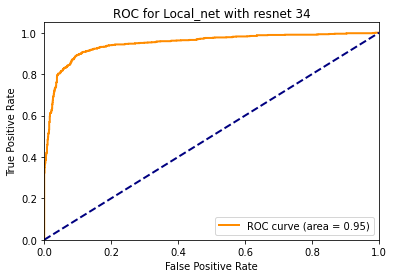

In [17]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y, pred)

roc_auc = metrics.auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Local_net with resnet 34')
plt.legend(loc="lower right")
plt.show()

In [18]:
from sklearn.metrics import confusion_matrix

threshold = 0.35

pred_t = pred > threshold
pred_t.astype(int)

cm = confusion_matrix(y,pred_t)

In [19]:
cm[0,0]/sum(cm[0,:]), cm[1,1]/sum(cm[1,:])

(0.933372992266508, 0.8339350180505415)

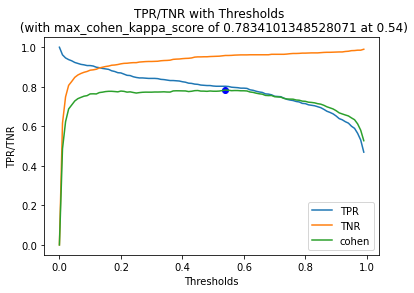

In [20]:
import numpy
from sklearn.metrics import cohen_kappa_score
mali = []
beni = []
cohen = []
tt = numpy.arange(0,1,0.01)
for thres in tt:
#     print(thres)
    pred_t = pred > thres
    pred_t.astype(int)
    cm = confusion_matrix(y,pred_t)
    mali.append(cm[1,1]/sum(cm[1,:]))
    beni.append(cm[0,0]/sum(cm[0,:]))
    cohen.append(cohen_kappa_score(y,pred_t))
# print(thresholds)
plt.figure(),plt.plot(tt,mali,label='TPR'),plt.plot(tt,beni,label='TNR'),plt.plot(tt,cohen,label='cohen')
plt.xlabel('Thresholds')
plt.ylabel('TPR/TNR')

plt.legend(loc="lower right")


net_max = cohen.index(max(cohen))
plt.title('TPR/TNR with Thresholds \n (with max_cohen_kappa_score of {} at {})'.format(max(cohen),tt[net_max]))
plt.scatter(tt[net_max], cohen[net_max], color='b')
plt.show()

In [21]:
from drutils.confusion_matrix import *
from fastai.vision import *
from fastai.callbacks.tracker import SaveModelCallback
from fastai.metrics import error_rate
import os
import matplotlib.pyplot as plt
import pandas as pd

In [22]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(4, 3))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)



#     plt.figure(figsize=(4, 3))
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
        
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

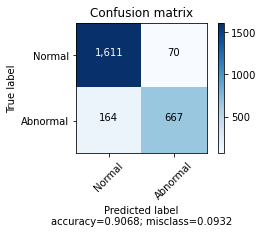

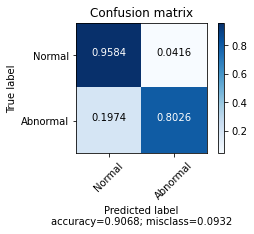

In [24]:
from sklearn.metrics import confusion_matrix

threshold = 0.54

pred_t = pred > threshold
pred_t.astype(int)

cm = confusion_matrix(y,pred_t)

plot_confusion_matrix(cm,('Normal','Abnormal'),normalize= False)
plot_confusion_matrix(cm,('Normal','Abnormal'),normalize= True)

In [25]:
a = 0.7

In [26]:
a>0.5

True

In [28]:
1-(a>0.50)

0

In [43]:
a = torch.rand(3,3)

In [44]:
a

tensor([[0.2847, 0.4820, 0.1940],
        [0.7670, 0.0734, 0.9933],
        [0.7518, 0.1041, 0.5967]])

In [35]:
a.shape

torch.Size([3, 3])

In [36]:
b = [0,2,1]

In [37]:
b = torch.tensor(b)

In [55]:
bb = b.reshape(-1,1)

In [54]:
b

tensor([0, 2, 1])

In [39]:
l = F.nll_loss(a,b)

In [40]:
l

tensor(-0.5024)

In [46]:
sm = nn.LogSoftmax(dim=1)

In [47]:
aa = sm(a)

In [48]:
aa

tensor([[-1.1415, -0.9442, -1.2322],
        [-1.0130, -1.7066, -0.7866],
        [-0.8669, -1.5147, -1.0220]])

In [56]:
l = F.nll_loss(aa,bb)

RuntimeError: multi-target not supported at ..\aten\src\THNN/generic/ClassNLLCriterion.c:20

In [53]:
l

tensor(1.1476)

In [59]:
a = np.random.rand(3,4)

In [66]:
b = np.random.rand(2,4)

In [72]:
t = [a,b]

In [73]:
np.array(t).shape

(2,)

In [74]:
t.pop()

array([[0.255251, 0.802925, 0.39936 , 0.069087],
       [0.192725, 0.195726, 0.765414, 0.068067]])

In [75]:
t.pop()

array([[0.269292, 0.443954, 0.016551, 0.314709],
       [0.903049, 0.930926, 0.752409, 0.969705],
       [0.035113, 0.174226, 0.025869, 0.240254]])

In [76]:
t[0]

IndexError: list index out of range